Game Plan:
1. Show that the choice of outcome variable does not matter very much because of the extremely high correlation between potential outcomes.
    - Create a nice looking correlation plot for the outcomes
    -  Probably try to create the sns.pairplot() although that function was very very slow
2.  Point out that the Spotify playlists are MUCH more successful than the typical user playlist
    - Can show that by plotting bar charts next to each other, group by whether owner == "spotify"
3.  Have to make a decision on what outcome variable to choose (or most likely a combination of outcome variables!)
4.  Look at univariate cuts of the outcome variable(s) with the predictors, just to try to give a sense of the relationship between the variables prior to modeling
5.  Build a baseline model that we can use for prediction and then we can compare this to a more advanced model -- will allow for simpler interpretations
6.  Build an ML model that we can then go compare efficacy with the baseline model.

Note: 
1.  We will likely want to run separate analyses broken out by owner == 'spotify' vs owner != 'spotify'
    a.  See if the importance of the other predictors is comparable for the two groups
2.  If a user streams 2 or more songs consecutively, does that count as 2 streams or only 1 since the stream were consecutive? 


Possible Options (no particular order)
1.  Look into multivariate methods to accommodate the various potential outcome variables (or could just pick one/create a PCA)
2.  Should probably think through how to use the 'skippers' data.  Could this be at all helpful in dealing with potential biases in how Spotify may promote playlists? 

Assumptions:
1.  This is a random sample of playlists.  If this a biased sample, then any generalizations that we make from the data is likely to be meaningfully inaccurate.
2.  Spotify treats each non-Spotify playlist equally in terms of promotion.  For examples, if the Spotify algorithms were promoting some genres above others at the time this data was collected, then we are unlikely to get a good read on how genre affects listenership.   
3.  (a) Spotify treats its own playlists differently than the non-Spotify playlists.  If this assumption is correct, then it is likely that Spotify playlists are not particularly comparable to non-Spotify playlists.  
    (b) Spotify treats its own playlists equally with each other.  Thus, an analysis with only Spotify playlists should be okay.  
4.  Each playlist included in the dataset has existed for at least two months.  This ensures that the monthly average users in the previous month variable is not biased by how long the playlist has existed.
5.  The Spotify algorithms do not amplify small variations in success.  If playlist A was slightly more successful than Playlist B two months ago under 'fair' algorithmic treatment, then the algorithms will not amplify playlist A over playlist B, and thus widen the gulf between the success of the two playlists.  In other words, there is a fair marketplace for the playlists to compete, where success does not necessarily beget success simply due to the algorithms.
6.  For the categorical variables, genre_1-genre_3 and mood_1-mood_3, when the value is '-' this is not a missing value, but is instead imparting the information that the given playlist does not easily fit into the predefined genre and mood types. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import KFold
import shap
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
outcome_vars_dict = {'streams': 'streams_today_any', 
                    'stream30s': 'streams_today_30s',
                    'monthly_stream30s': 'streams_month_30s',                  
                    'dau': 'users_today_30s', 
                    'wau': 'users_week_30s', 
                    'mau': 'users_month_30s', 
                     'users': 'users_month_any',
                    'mau_previous_month': 'users_previousmonth_30s',
                    'mau_both_months': 'users_bothmonths_30s',
               }

outcome_vars = list(outcome_vars_dict.values())


raw_data = pd.read_table('data/playlist_summary_external.txt')
raw_data = raw_data.rename(columns = outcome_vars_dict)
spotify_data = raw_data.query('owner == "spotify"')
nonspotify_data = raw_data.query('owner != "spotify"')
# outcome_vars = ['streams', 
#                 'stream30s', 
#                 'dau', 
#                 'wau', 
#                 'mau', 
#                 'mau_previous_month',
#                 'mau_both_months',
#                 'users',
#                 'monthly_stream30s',
#                ]




predictor_vars = ['n_tracks', 
                 'n_local_tracks',
                  'n_artists',
                  'n_albums',
                  'genre_1',
                  'genre_2',
                  'genre_3',
                  'mood_1',
                  'mood_2',
                  'mood_3'
                 ]

# Introduction

The data under consideration for these analyses consists of 403,366 distinct playlists, with 314,899 distinct playlist owners.  Of the 314,899 unique playlist owners, 261,040 (83%) have exactly one playlist in the data.  Of the owners with more than one playlist, Spotify itself has the most, with 399.  The data is composed of only playlists from US owners, and thus extrapolating any of these analyses to other countries is likely unwarranted or should be done with great caution.  Each playlist is categorized by its top three genres and top three moods.  There are 26 genres and 27 moods under consideration.

There are a number of potential measures of playlist success included in this dataset.  Specifically, we have (1) The number of streams from the playlist today, (2) the number of streams greater than 30 seconds today, (3) the number of active users today, where an active user is defined as having a stream $>30$ seconds, (4) the number of active users in the past week, (5) the number of active users in the past month, (6) the number of users who had a stream this playlist for any length of time in the past month, (7) the number of active users in the previous month, (8) the total number of $>30$ second streams in the past month, (9) the number of users who were active this month and the previous month, and (10) the number of $>30$ second streams by the playlist owner in the past month.  The data also includes the number of users who skipped more than 90% of their total streams today who also used this playlist, which could be used as a reverse encoded outcome variable.  

Some of the potential predictors of stream success include: (1) the number of tracks in the playlist, (2) the number of tracks that were added to the playlist today, (3) The number of unique artists in the playlist, (4) the number of unique albums in the playlist, (5-7) the first, second and third most common genre found in the playlist, (8-10) the first, second and third most common mood found in the playlist, and (11) the tokens associated with the playlist.

There are two Spotify-owned playlists that constitute extreme outliers across each of the potential outcome variables.  The first is a pop, Dance & House, Indie Rock playlist with 100 tracks and has tokens 'top', 'tracks', 'currently', 'spotify'.  The second is a pop, R&B, Dance & House with 51 tracks and has tokens 'top', and 'hits'.  These two playlists have more than three times as many streams today as their nearest competitor and more than four times as many $>30$ second streams in the past month as the nearest competitor.  For the purposes of plotting, these playlists will be removed.

## Comparing Spotify-Owned and Non-Spotify-Owned Playlists

Even after removing the two most successful Spotify-owned playlists, there is still a wide gulf between the Spotify-owned and non-Spotify-owned playlists.  To illustrate this, consider the boxen plot below, which shows the distribution of each of the potential outcome variables stratified by whether the playlist is Spotify-owned.  We observe that the Spotify-owned playlists are much more successful than the vast majority of non-Spotify-owned playlists.  However, there are a few user-created playlists that can rival an average Spotify-created playlist.  

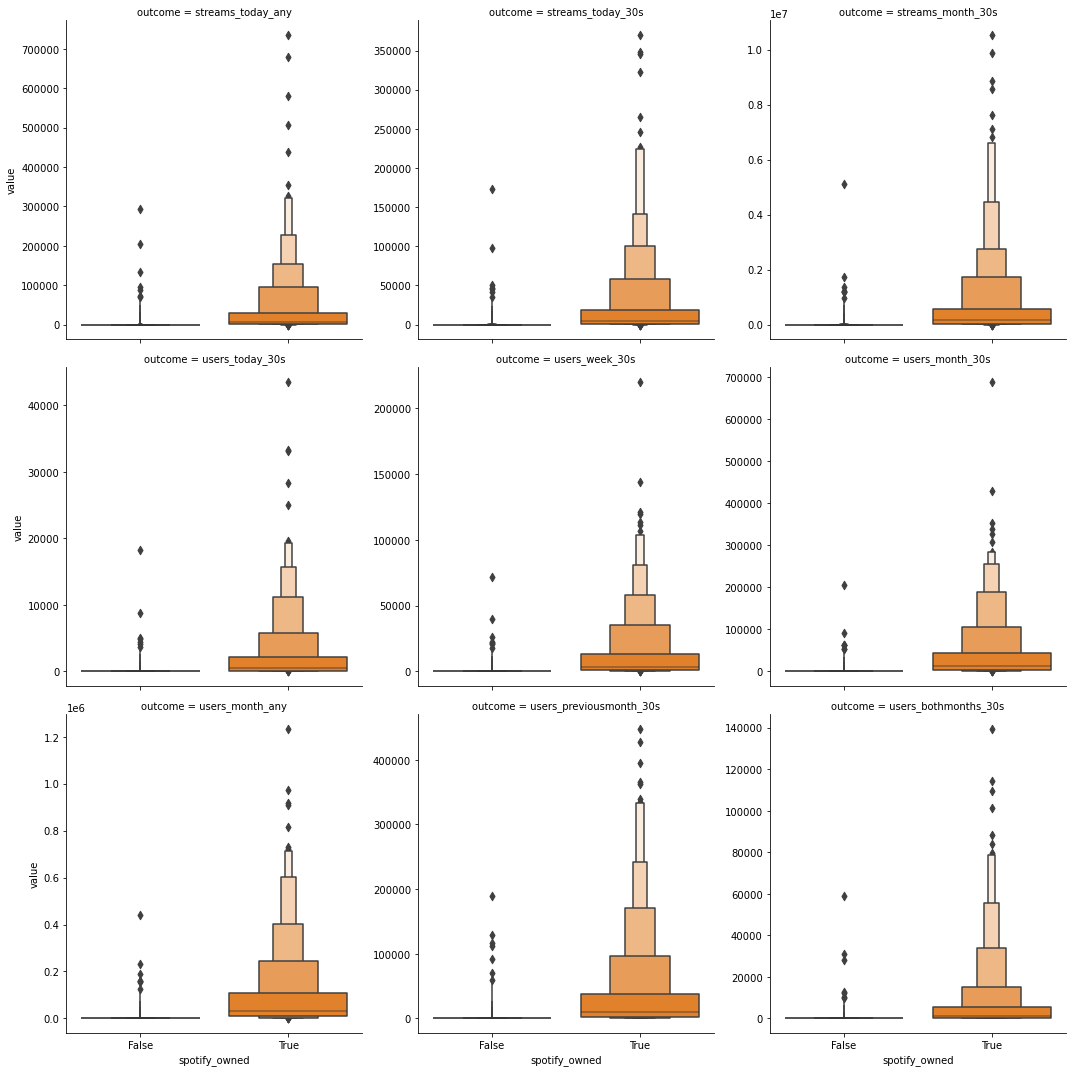

In [3]:
raw_data['spotify_owned'] = raw_data['owner'] == 'spotify'
comparison_data = (raw_data.
                   drop(index = [163726, 152032]).
                   loc[:, ['spotify_owned'] + outcome_vars].
                   melt(id_vars = 'spotify_owned',
                       var_name = 'outcome',
                       value_name = 'value')
                  )
sns.catplot(data = comparison_data,
            kind = 'boxen',
            col = 'outcome',
            col_wrap = 3,
            sharey = False,
            y = 'value', 
            x = 'spotify_owned')

## Exploration of Potential Outcomes

Because there is such an enormous difference between Spotify-created and user-created playlists, we will continue our data exploration stratifying by whether the playlist is Spotify-created.  In results not shown, the correlation between the number of $>30$ second streams by the playlist owner is **much** more weakly correlated with the other potential outcome variables than, and thus will not be included in the following analysis.  

To begin understanding the relationship between the potential outcomes of interest, we present a heatmap of the Pearson correlation between each of the outcomes.  We create one such heatmap for the non-Spotify-owned playlists and another for the Spotify-owned playlists.  Amongst the non-Spotify-owned playlists, we see that the minimum correlation between any of the outcomes is 0.78, thus signifying a great deal of correlation between our potential outcomes.  While all potential outcomes are highly correlated, the mostly weakly correlated outcomes are the outcomes related to playlists' longer-term success (i.e. the monthly average users in the given month and the previous month) with the more recent measures of success (i.e. the number of total and >30 second streams today and the number of active users today and in the past week)  Amongst the Spotify-owned playlists, the potential outcomes are even more highly correlated, with the smallest correlation being 0.91.  The Spotify-owned playlists exhibit a similar general pattern to those of the non-Spotify-owned in that the weakest correlation between the outcomes is between the more long-term measures of success and the measures of success in the more recent past.  However, the degree of correlation is still immense between monthly active users over the past two months and the number of streams that occurred today, thus indicating that Spotify playlists tend to have considerable 'staying power'.  Of course, if more successful playlists in the past are algorithmically pushed to users, then this could become a self-fulfilling prophecy rather than a true indication of how 'intrinsically good' the palylist is.  

In [4]:
def plot_outcome_corr(data):
    plot_data = data.loc[:, outcome_vars]
    plot_data_corr = plot_data.corr()
    return plot_data, sns.heatmap(plot_data_corr, annot = True, cmap = 'BrBG')

Text(0.5, 1.0, 'Correlation Heatmap of Potential Outcome Variables for the non-Spotify-owned Playlists')

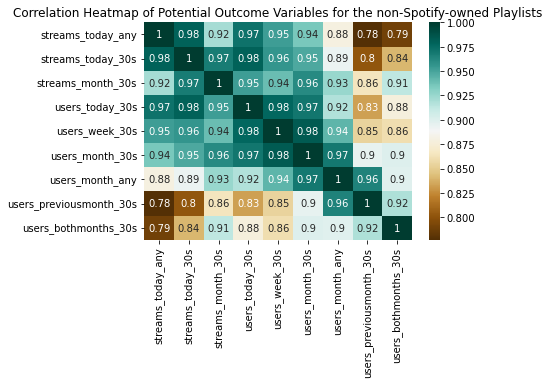

In [5]:
nonspotify_outcome_data, nonspotify_heatmap = plot_outcome_corr(nonspotify_data)
nonspotify_heatmap.set_title('Correlation Heatmap of Potential Outcome Variables for the non-Spotify-owned Playlists')

Text(0.5, 1.0, 'Correlation Heatmap of Potential Outcome Variables for the Spotify-owned Playlists')

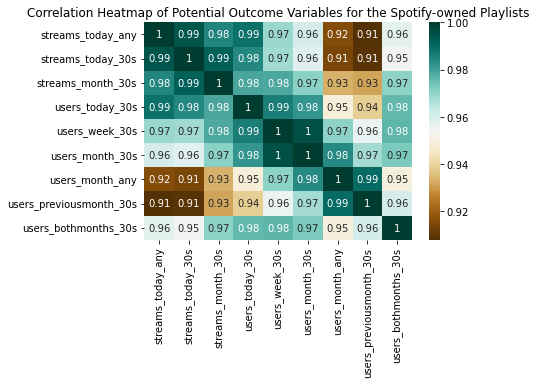

In [6]:
spotify_outcome_data, spotify_heatmap = plot_outcome_corr(spotify_data)
spotify_heatmap.set_title('Correlation Heatmap of Potential Outcome Variables for the Spotify-owned Playlists')

## Factor Analysis of Potential Outcomes

We will continue our exploration of the relationship between the potential outcomes by performing a factor analysis.

In [7]:
nonspotify_outcome_scaled = StandardScaler().fit_transform(nonspotify_outcome_data)
spotify_outcome_scaled = StandardScaler().fit_transform(spotify_outcome_data)

In [8]:
feature_names = outcome_vars

def plot_pca_fa(X, n_comps, fig_title):

    methods = [
        ("PCA", PCA()),
        ("FA", FactorAnalysis(max_iter = 20)),
        #("Varimax FA", FactorAnalysis(max_iter = 20, rotation="varimax")),
    ]
    fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8))

    for ax, (method, fa) in zip(axes, methods):
        fa.set_params(n_components=n_comps)
        fa.fit(X)

        components = fa.components_.T
        #print("\n\n %s :\n" % method)
        #print(components)

        vmax = np.abs(components).max()
        ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
        ax.set_yticks(np.arange(len(feature_names)))
        if ax.is_first_col():
            ax.set_yticklabels(feature_names)
        else:
            ax.set_yticklabels([])
        ax.set_title(str(method))
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Comp. 1", "Comp. 2"])
    fig.suptitle(fig_title)
    plt.tight_layout()
    plt.show()

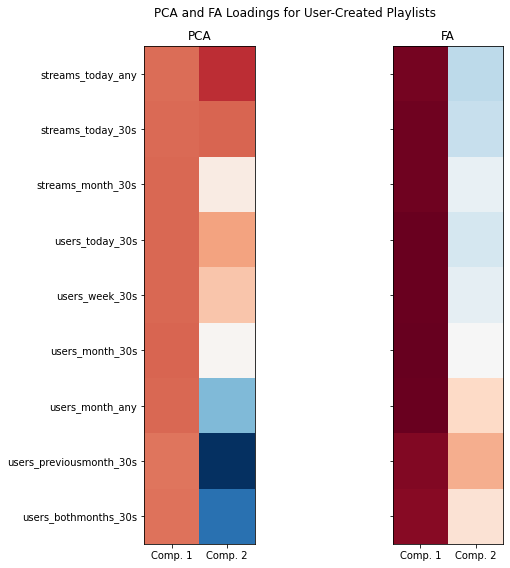

In [9]:
plot_pca_fa(X = nonspotify_outcome_scaled, 
            n_comps = 2,
           fig_title = 'PCA and FA Loadings for User-Created Playlists'
           )


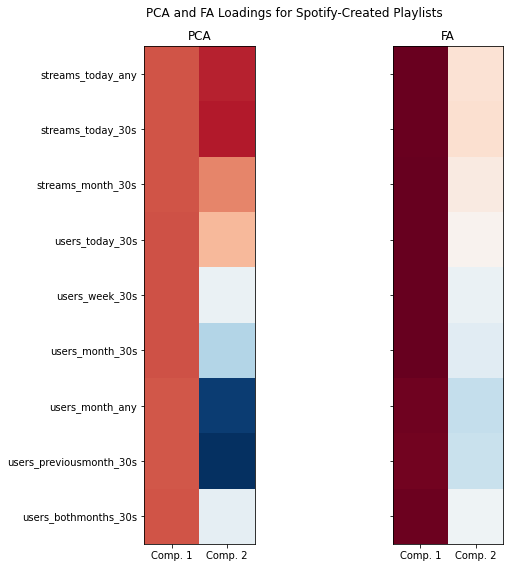

In [10]:
plot_pca_fa(X = spotify_outcome_scaled, 
            n_comps = 2,
           fig_title = 'PCA and FA Loadings for Spotify-Created Playlists'
           )

## Exploration of Predictors of Interest


In [11]:
predictor_data = raw_data.loc[:, ['spotify_owned'] + predictor_vars]

Note that for the plots below, we drew a random sample of user-created playlists for these plots in order for them not to visually swamp the Spotify-created playlists.  We can see from the plot below that, unsurprisingly, as a playlist's number of tracks increases so do the number of artists and albums.  We will thus define tracks per artist and tracks per album as scaled measures of the number of artists and albums that account for the overall size of the playlist.  Also, note that the distribution of number of tracks, artists and albums does not vary between Spotify-created and user-created to the degree that the outcome variables do.  However, we still observe some difference between user-created and Spotify-created playlists, namely that user-created playlists tend to have moer tracks, artists and albums, with some user-created playlists having many more of each.

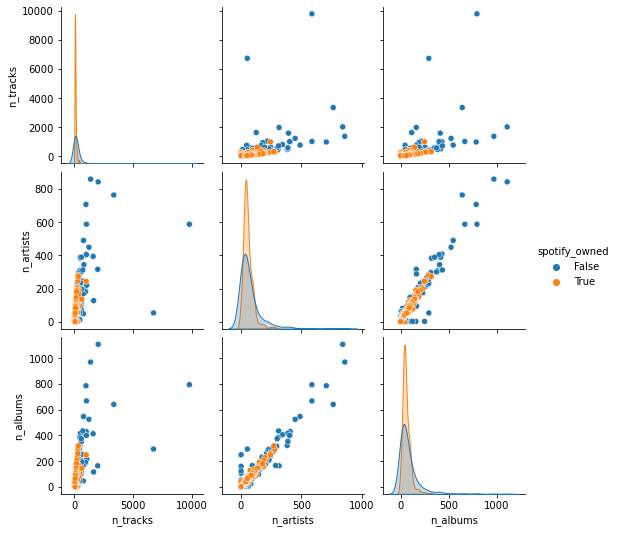

In [12]:
np.random.seed(2)
continuous_predictors = (predictor_data.
                         loc[:, ['spotify_owned',
                                 'n_tracks', 
                                 #'n_local_tracks', 
                                 'n_artists', 
                                 'n_albums',]].
                         groupby('spotify_owned').
                         # melt(var_name = 'predictor',
                         #     value_name = 'value').
                         sample(399)                       
                        )

sns.pairplot(continuous_predictors,
            hue = 'spotify_owned')

In [13]:
predictor_data['tracks_per_artist'] = predictor_data.n_tracks / predictor_data.n_artists
predictor_data['tracks_per_album'] = predictor_data.n_tracks / predictor_data.n_albums

Let's consider the correlation of the new scaled measures of artists and albums as well as whether we observe differences between the user-created and Spotify-created playlists.  Notice that the distribution of tracks per artist and tracks per album appear quite similar for the user-created and Spotify-created playlists.  Spotify-created playlist appear to exhibit a little bit more artist and album diversity than the user-created playlists, but the difference is miniscule compared to the outcome variables.  

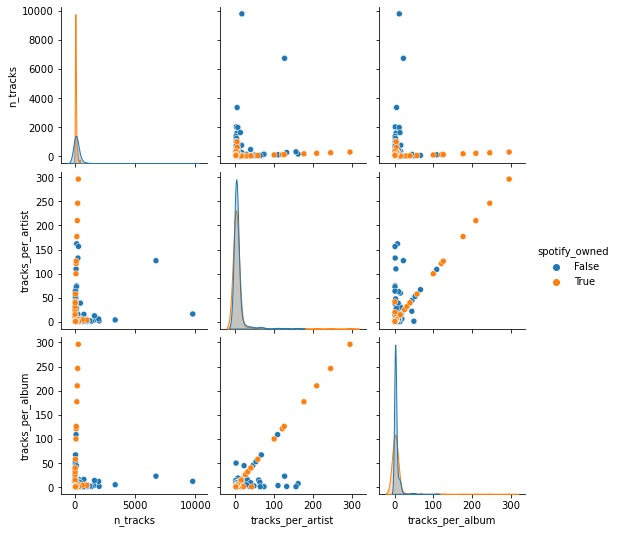

In [14]:
np.random.seed(2)
scaled_predictors = (predictor_data.
                         loc[:, ['spotify_owned',
                                 'n_tracks', 
                                 #'n_local_tracks', 
                                 'tracks_per_artist', 
                                 'tracks_per_album',]].
                         groupby('spotify_owned').
                         # melt(var_name = 'predictor',
                         #     value_name = 'value').
                         sample(399)                     
                        )

sns.pairplot(scaled_predictors,
            hue = 'spotify_owned')

We now turn our attention to describing the categorical predictors: genre and mood.

In [15]:
cat_vars = ['genre_1',
            'genre_2',
            'genre_3',
            'mood_1',
            'mood_2',
            'mood_3'
            ]

cat_preds = (predictor_data.
             loc[:, ['spotify_owned'] + cat_vars]
            )


In [16]:
def plot_cat_var(pred):

    cat_order = (cat_preds[pred].
                 value_counts().
                 reset_index().
                 rename(columns = {pred: 'count',
                                   'index': pred
                                  }).
                 sort_values('count', ascending = False)            
                )

    my_plot = sns.barplot(
        data = cat_order,
        y = pred,
        x = 'count'
    )

    my_plot.set_title(f'Distribution of {pred}')
    
    return my_plot



<AxesSubplot:title={'center':'Distribution of genre_1'}, xlabel='count', ylabel='genre_1'>

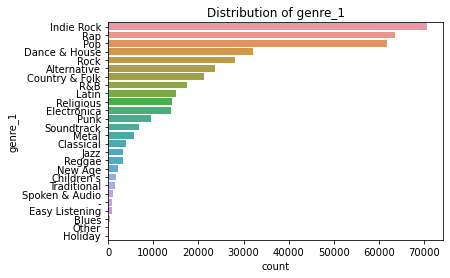

In [17]:
plot_cat_var('genre_1')

<AxesSubplot:title={'center':'Distribution of genre_2'}, xlabel='count', ylabel='genre_2'>

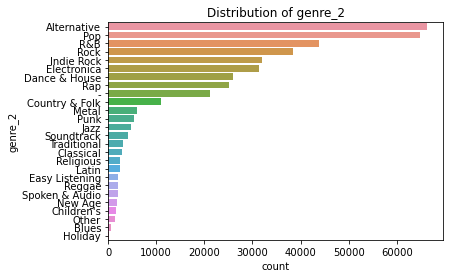

In [18]:
plot_cat_var('genre_2')

<AxesSubplot:title={'center':'Distribution of genre_3'}, xlabel='count', ylabel='genre_3'>

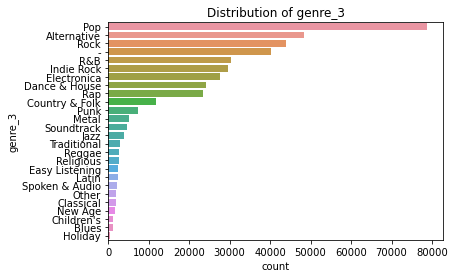

In [19]:
plot_cat_var('genre_3')

<AxesSubplot:title={'center':'Distribution of mood_1'}, xlabel='count', ylabel='mood_1'>

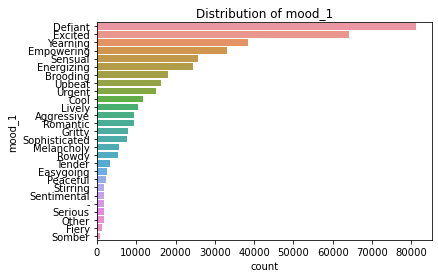

In [20]:
plot_cat_var('mood_1')

<AxesSubplot:title={'center':'Distribution of mood_2'}, xlabel='count', ylabel='mood_2'>

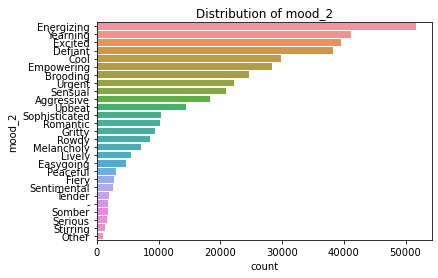

In [21]:
plot_cat_var('mood_2')

<AxesSubplot:title={'center':'Distribution of mood_3'}, xlabel='count', ylabel='mood_3'>

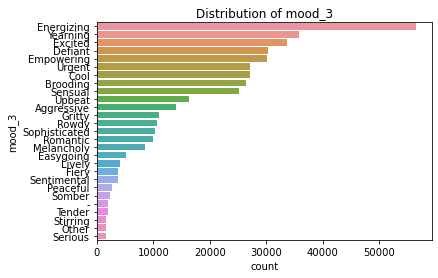

In [22]:
plot_cat_var('mood_3')

We now need to get a sklearn pipeline built for modeling the various outcomes.  We will try to predict the outcomes 'users_today_30s' and 'users_bothmonths_30s'.  We choose 'users_today_30s' because amongst the user-created playlists, it very highly correlated with streams_today_any, streams_today_30s, streams_month_30s, users_week_30s, and users_month_30s (with the minimum correlation being 0.95).  It is also less correlated with users_previousmonth_30s (0.83) and users_bothmonths_30s (0.88).  We choose 'users_bothmonths_30s' because (1) it is less corelated than many of the other outcomes and (2) it is a good measure of a playlist's longer-term staying power.

In [51]:
def fit_lgb_mod(X, y):

    lgb_data = lgb.Dataset(data = X,
                          label = y,
                          params = {'verbose': -1}
                          )

    lgb_params = {'learning_rate': 1.0,
              'objective': 'huber' # deal with outliers 
               }

    lgb_cv = lgb.cv(params = lgb_params,
                    train_set = lgb_data,
                    num_boost_round = 10000,
                    nfold = 10,
                    verbose_eval = -1, 
                    stratified = False,
                    early_stopping_rounds = 25,
                    return_cvbooster = True)

    lgb_booster = lgb_cv.get('cvbooster')
    n_trees = lgb_booster.best_iteration
    
    lgb_mod = lgb.train(params = lgb_params,
                       train_set = lgb_data,
                       num_boost_round = n_trees,
                       verbose_eval = -1)
    
    return lgb_mod




In [52]:
X = predictor_data.drop(columns = ['n_artists', 'n_albums'])
cat_columns = ['genre_1', 'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3']
for column in cat_columns:
    X[column] = X[column].astype('category')


In [65]:
# Get the modeling input data for the Spotify-only models and no-Spotify models
X_spotify = X.query('spotify_owned == True').drop(columns = 'spotify_owned')
users_today_spotify = raw_data.query('spotify_owned == True').loc[:, 'users_today_30s']
users_bothmonths_spotify = raw_data.query('spotify_owned == True').loc[:, 'users_bothmonths_30s']


# Get the modeling input data for the Spotify-only models and no-Spotify models
X_nonspotify = X.query('spotify_owned == False').drop(columns = 'spotify_owned')
users_today_nonspotify = raw_data.query('spotify_owned == False').loc[:, 'users_today_30s']
users_bothmonths_nonspotify = raw_data.query('spotify_owned == False').loc[:, 'users_bothmonths_30s']

In [66]:
%%capture
users_today_spotify_mod = fit_lgb_mod(X = X_spotify,
                                     y = users_today_spotify)

In [67]:
%%capture
users_bothmonths_spotify_mod = fit_lgb_mod(X = X_spotify,
                                           y = users_bothmonths_spotify)

In [75]:
def create_model_explanations(mod, X, n_samples = 20000, plot_top_n = 3):

    n_samples = min(n_samples, len(X))
    explainer = shap.TreeExplainer(mod)
    X_reduced = X.sample(n_samples)
    shap_values = explainer.shap_values(X_reduced)
    
    # shap_summary = shap.summary_plot(
    #     np.delete(shap_values, obj = 0, axis = 1), 
    #     X_reduced.drop(columns = 'spotify_owned'))
    
    shap_summary = shap.summary_plot(shap_values, X_reduced)
    
    plt.show(shap_summary)
    
    top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
    
    for i in range(plot_top_n):
        shap.dependence_plot(top_inds[i], shap_values, X_reduced)

# Modeling Results for Number of Users Today Amongst Spotify-Owned Playlists

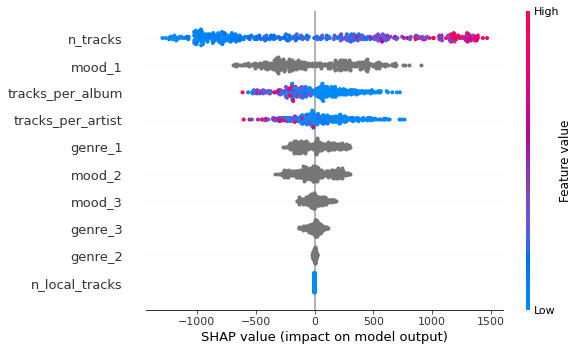

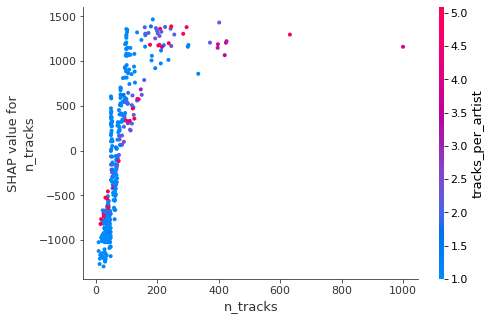

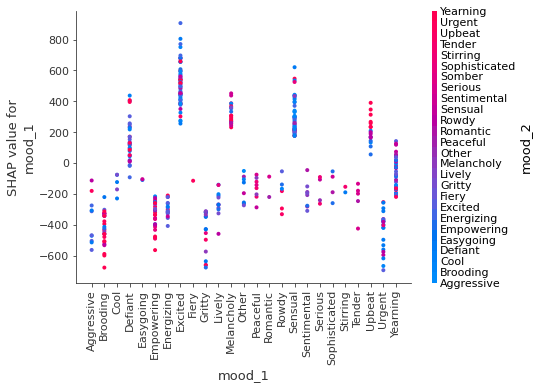

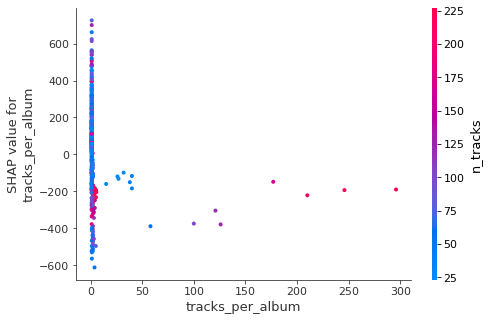

In [76]:
create_model_explanations(mod = users_today_spotify_mod,
                          X = X_spotify)

# Modeling Results for Number of Users in Current and Previous Month Amongst Spotify-Owned Playlists

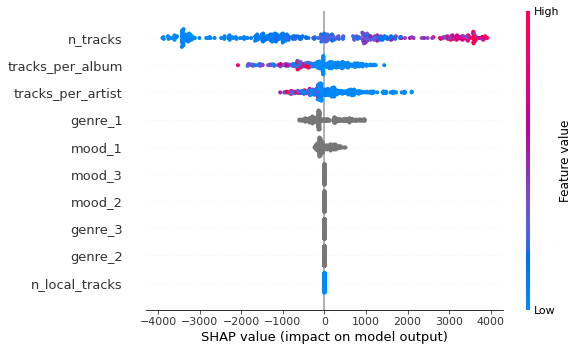

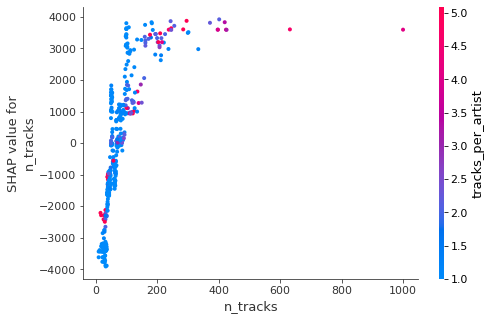

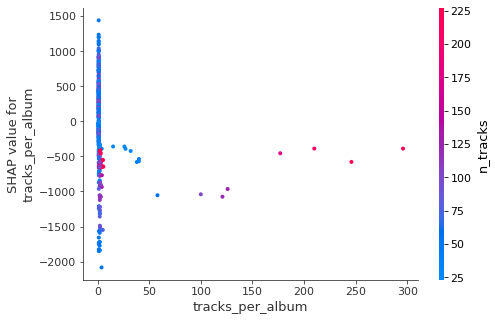

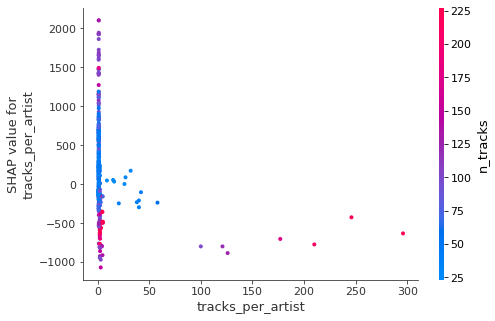

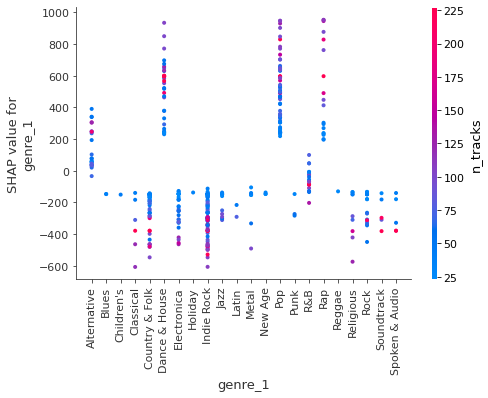

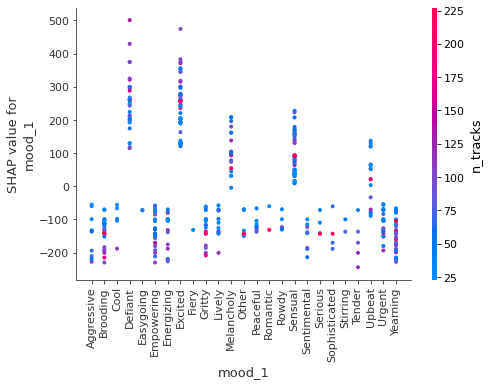

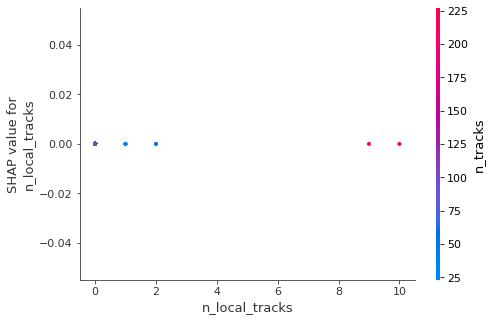

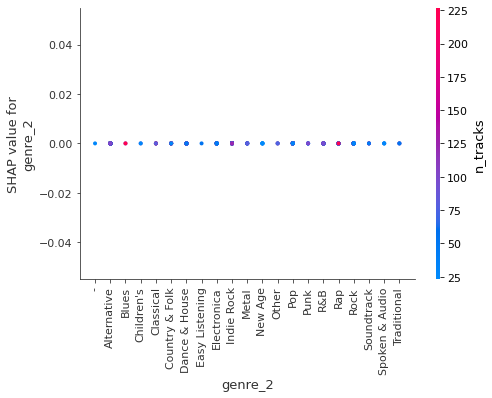

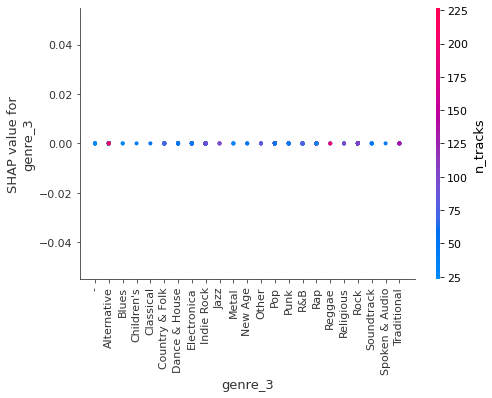

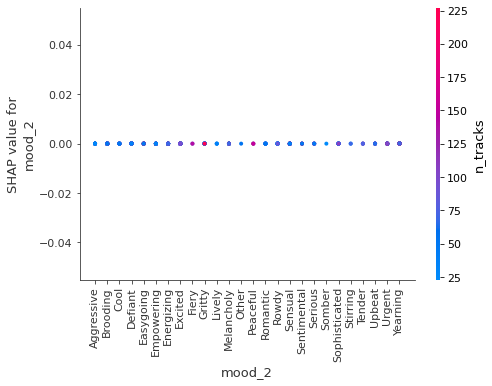

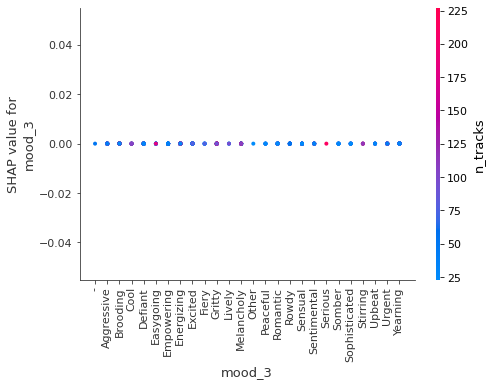

In [70]:
create_model_explanations(mod = users_bothmonths_spotify_mod,
                          X = X_spotify)

In [71]:
%%capture
users_today_nonspotify_mod = fit_lgb_mod(X = X_nonspotify,
                                     y = users_today_nonspotify)

In [72]:
%%capture
users_bothmonths_nonspotify_mod = fit_lgb_mod(X = X_nonspotify,
                                     y = users_bothmonths_nonspotify)

# Modeling Results for Number of Users Today Amongst User-Owned Playlists

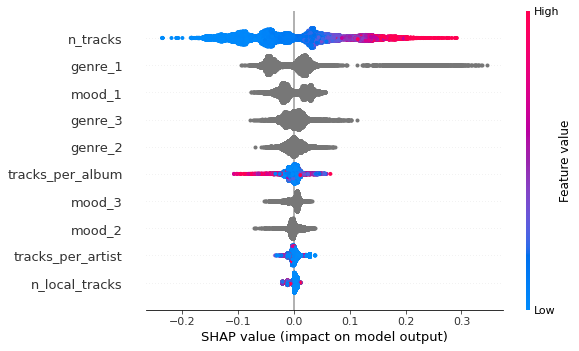

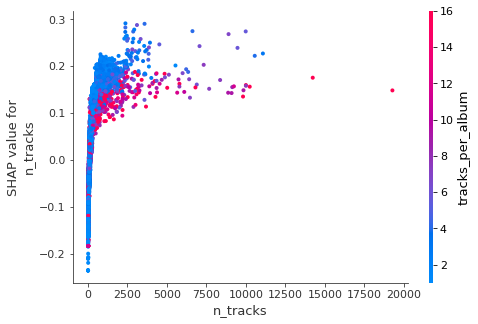

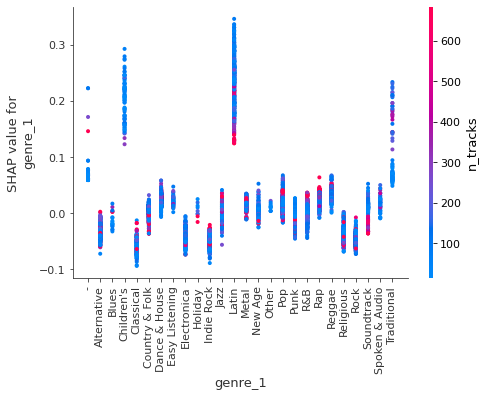

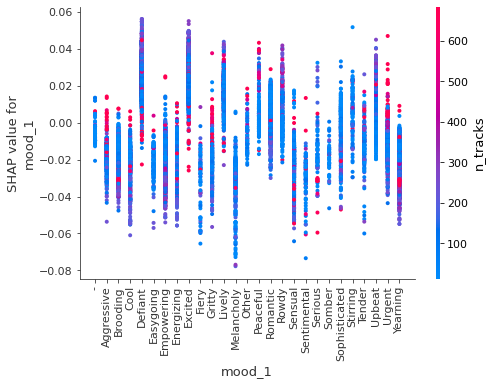

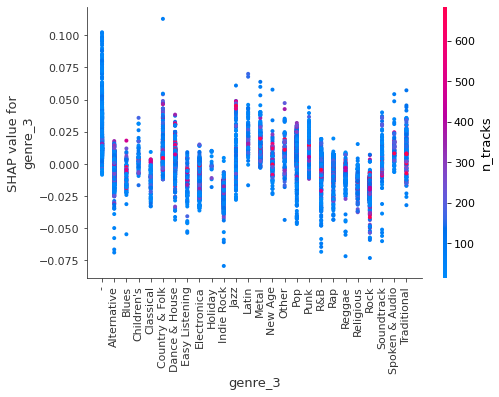

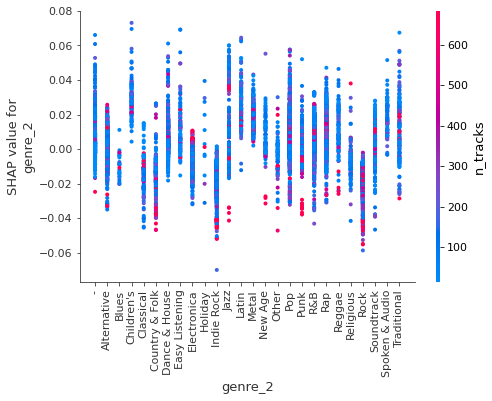

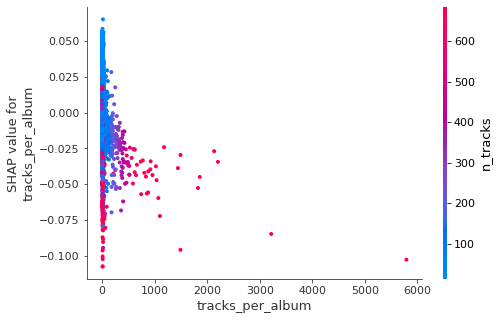

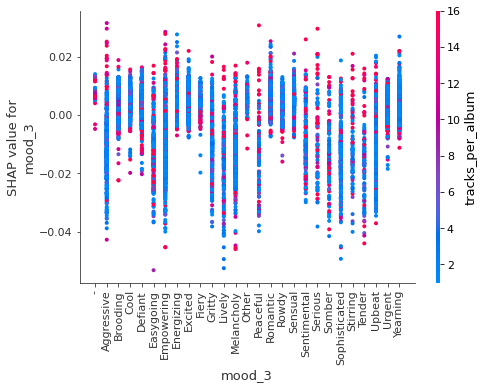

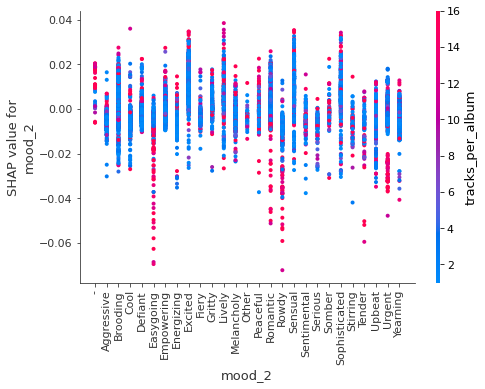

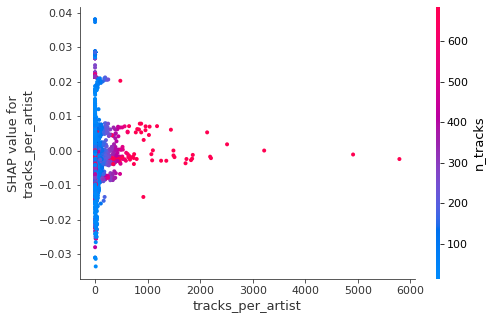

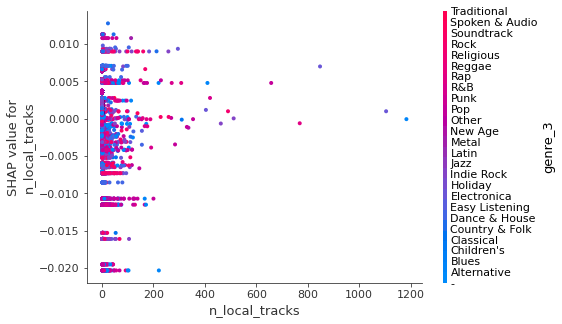

In [73]:
create_model_explanations(mod = users_today_nonspotify_mod,
                          X = X_nonspotify)

# Modeling Results for Number of Users in Current and Previous Month Amongst User-Owned Playlists

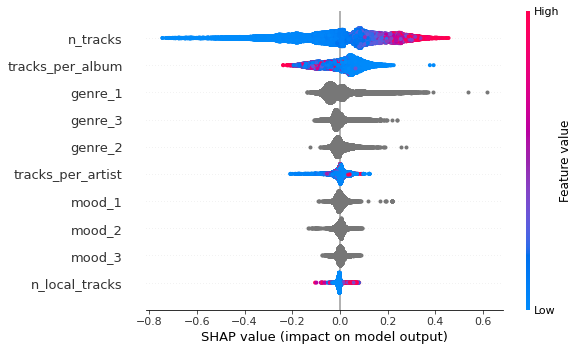

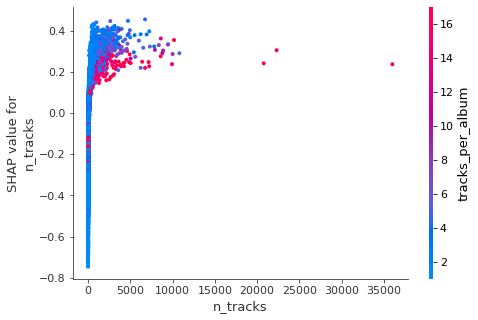

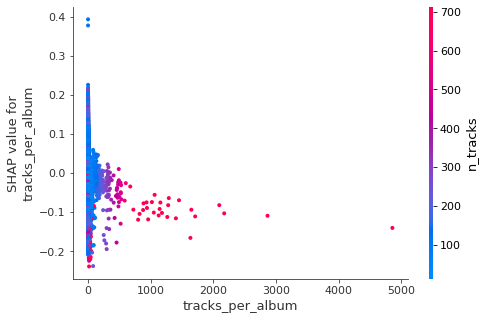

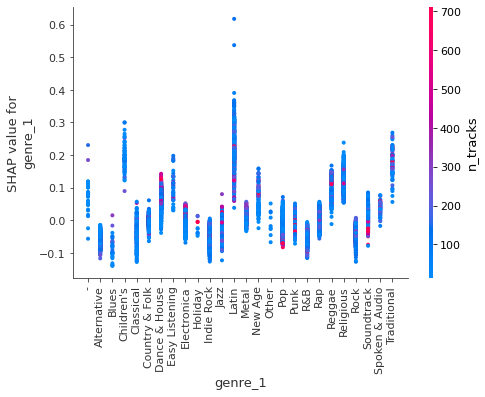

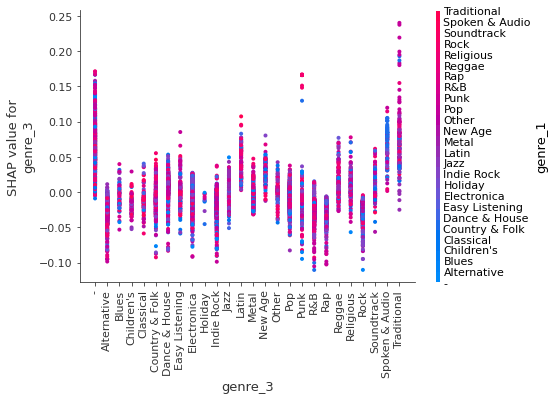

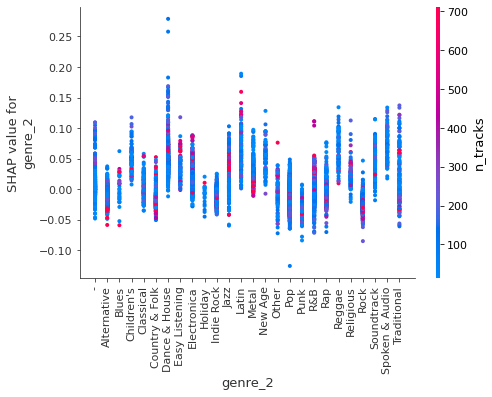

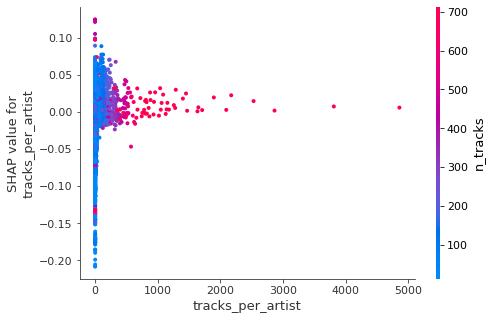

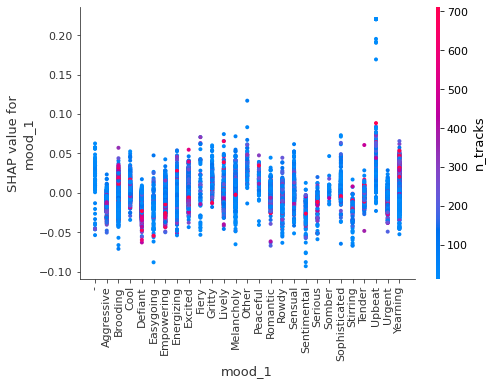

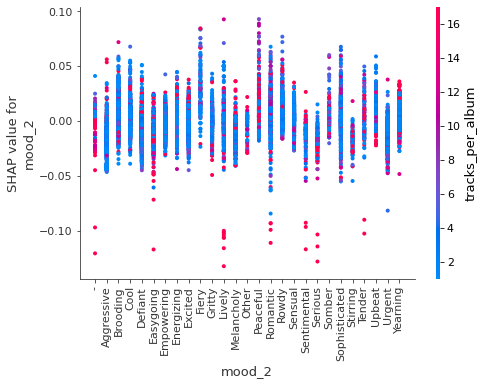

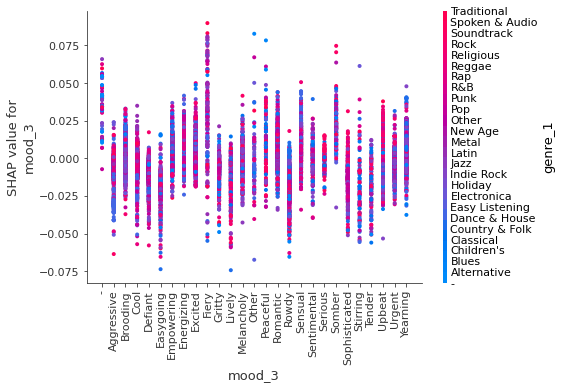

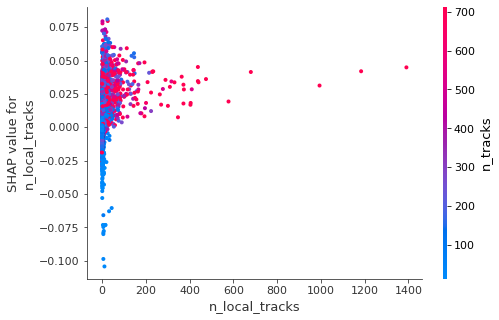

In [74]:
create_model_explanations(mod = users_bothmonths_nonspotify_mod,
                          X = X_nonspotify)

In [27]:
#shap.initjs()
# shap.force_plot(base_value = explainer.expected_value,
#                shap_values = shap_values,
#                features = X_reduced)

In [28]:
#shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])